## The base ViT - GPT-2 Image Captioner

### Model Overview

To build a specialized fashion descriptor, a base model is needed which can describe generic images. A simple and effective way to build an image captioning model is training a pipeline with a vision transformer as encoder and a large language model as the decoder. The pipeline works by producing embeddings of the image through the encoder and teaching the language model to generate when the embeddings are passed as inputs. To achieve this, cross-attention needs to be added to the decoder as well as its native self-attention.

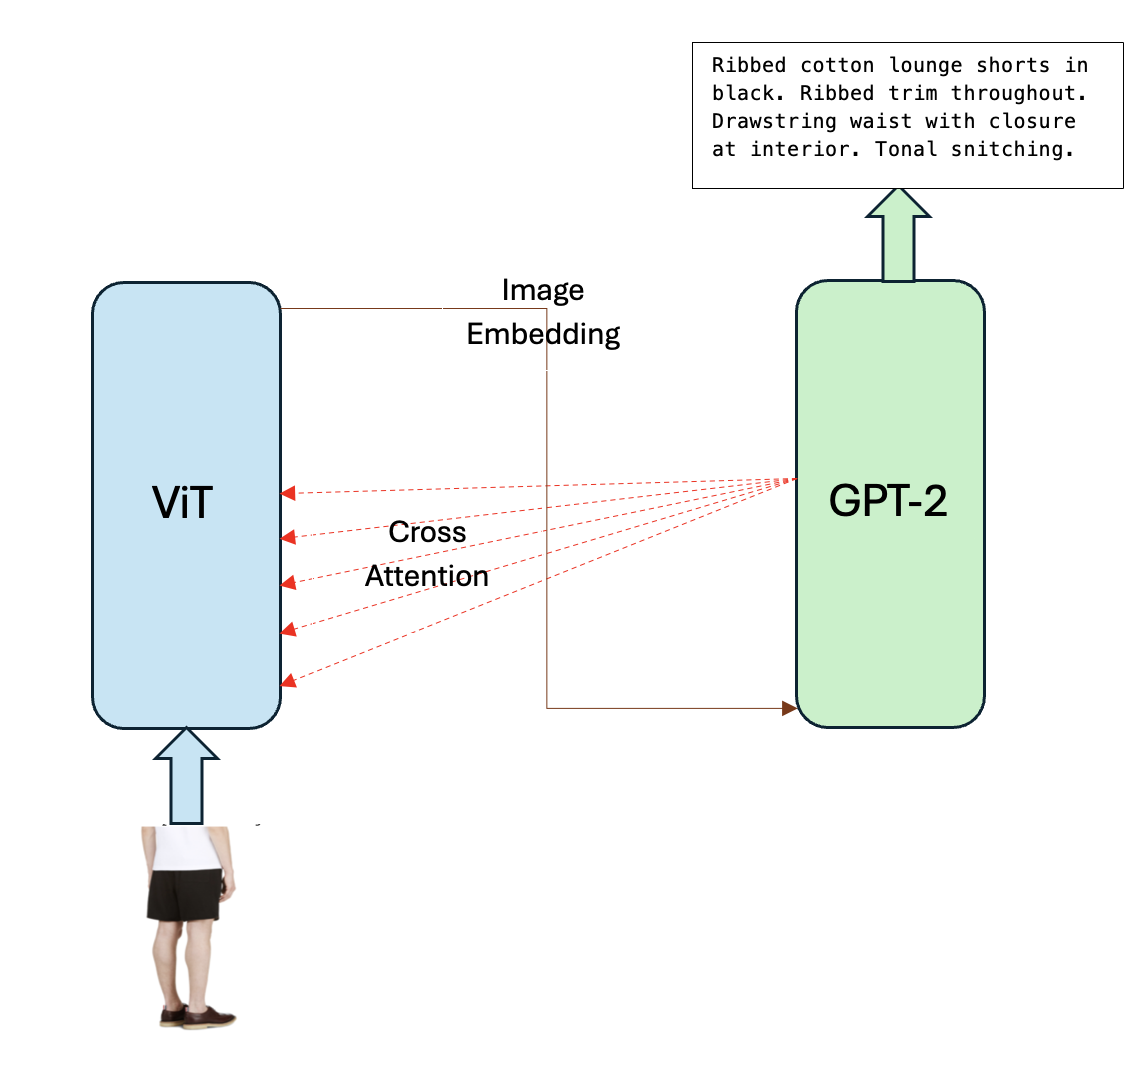

The model can be trained immediately with the FashionGen data encompassing clothes and descriptions. However, since ViT's weights are set to classify generic images and GPT-2's weights are set to generate language. As a result, if the pipeline is trained on the clothes data, the model may converge to a subpar local optimum. To avoid this, first the pipeline is trained to modify the weights until the model can caption generic images well. Next, those modified weights can be tuned further with the fashion data.

Note that while the project is different, aspects of the code, especially model definition and training sections are based on [link](https://www.kaggle.com/code/burhanuddinlatsaheb/image-captioning-vit-gpt2/notebook).

### Model Definition

In [ ]:
!pip install --upgrade accelerate

To speed-up training, GPU acceleration is employed if GPU is available.

In [ ]:
import os
from google.colab import drive
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import AutoImageProcessor, AutoTokenizer
from transformers import VisionEncoderDecoderModel, GPT2Config, ViTConfig


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA L4


In [ ]:
drive.mount('/content/drive')
os.chdir('./drive/MyDrive')

Mounted at /content/drive


Since the dataset includes ~8,100 images, even one batch takes up a lot of memory. To avoid running out of memory, gradient checkpointing is used. While a batch size of 16 would be too large with Colab's GPU RAM, an effective batch size of 16 is achieved by setting batch sizes to 4 and gradient accumulation steps to 4 as well. Since both ViT and GPT-2 are large models, mixed precision training is also used to cut down training time, if NVIDIA GPUs are available. Finally, to log training details, the model is evaluated against the validation data every 500 steps and saved every 1000 steps.

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

class config :
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "openai-community/gpt2-large"
    SEED = 42
    TRAIN_BATCH_SIZE = 4
    VAL_BATCH_SIZE = 4
    LABEL_MASK = -100
    LR = 5e-5
    MAX_LEN = 32
    WEIGHT_DECAY = 0.01
    NUM_BEAMS = 5
    NO_REPEAT_NGRAM_SIZE = 3
    LENGTH_PENALTY = 2.5
    EPOCHS = 5
    SAVE_STEPS = 1000
    EVAL_STEPS = 500
    WARMUP_STEPS = 500
    GRAD_ACC_STEPS = 4
    GRADIENT_CHECKPOINTING = True
    MIXED_PRECISION_TRAINING = True
    SAVE_TOTAL_LIMIT = 3

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    if token_ids_1 is None:
        return [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    else:
        return [self.bos_token_id] + token_ids_0 + [self.sep_token_id] + token_ids_1 + [self.eos_token_id]

The image processor for ViT and the tokenizer for GPT-2 are loaded to preprocess the data

In [ ]:
feature_extractor = AutoImageProcessor.from_pretrained(config.ENCODER)
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Finally, the model is defined with ViT as the image encoder and GPT-2 as the caption decoder. Since GPT-2 is a decoder-only model, adding cross-attention needs to be explicitly specified.

In [ ]:
encoder_config = ViTConfig.from_pretrained(config.ENCODER)

decoder_config = GPT2Config.from_pretrained(config.DECODER,
                                            is_decoder=True,
                                            add_cross_attention=True)

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(\
    config.ENCODER, config.DECODER, encoder_config = encoder_config,
    decoder_config = decoder_config,low_cpu_mem_usage=True)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at openai-community/gpt2-large and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Special tokens for the model are set based on special tokens for the GPT-2 model, the model's search method for generation is set to be beam search (with 5 beams). To avoid overly lengthy captions, a max length of 32, a non-repeat condition on trigrams, and an exponential length penalty of 2.5 is also set.

In [ ]:
model.config.update({
    "decoder_start_token_id": tokenizer.bos_token_id,
    "pad_token_id": tokenizer.pad_token_id,
    "vocab_size": model.config.decoder.vocab_size,
    "eos_token_id": tokenizer.eos_token_id,
    "max_length": config.MAX_LEN,
    "early_stopping": True,
    "num_beams": config.NUM_BEAMS,
    "length_penalty": config.LENGTH_PENALTY,
    "no_repeat_ngram_size": config.NO_REPEAT_NGRAM_SIZE
})

### Data Loading

The file captions.txt includes image file names and captions for all images in the Flickr8k dataset.

In [ ]:
pd.set_option('display.max_colwidth', None)

data_df = pd.read_csv('./Flickr8k/captions.txt', sep=',')

data_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                                                    caption  
0  A child in a pink dress is climbing up a set of stairs in an entry way .  
1                                     A girl going into a wooden building .  
2                          A little girl climbing into a wooden playhouse .  
3                      A little girl climbing the stairs to her playhouse .  
4                 A little girl in a pink dress going into a wooden cabin .

Since each image has 5 captions, unique images need to be extracted and training, validation, and test splits need to be made based on the unique images. Then rows with these images in the full schema are obtained by performing an inner join on the image file names.

In [ ]:
all_images = data_df['image'].unique()
dev_images, test_images = train_test_split(all_images, test_size=1000, random_state=config.SEED)
train_images, val_images = train_test_split(dev_images, test_size=1000, random_state=config.SEED)

train_images = pd.DataFrame(train_images, columns=['image'])
val_images = pd.DataFrame(val_images, columns=['image'])
test_images = pd.DataFrame(test_images, columns=['image'])

train_df = data_df.join(train_images.set_index("image"), on="image", how="inner")
val_df = data_df.join(val_images.set_index("image"), on="image", how="inner")
test_df = data_df.join(test_images.set_index("image"), on="image", how="inner")

In [ ]:
train_df.to_csv('./Flickr8k/train.csv', index=False)
val_df.to_csv('./Flickr8k/val.csv', index=False)
test_df.to_csv('./Flickr8k/test.csv', index=False)

Note that the dataset class needs to be customized to fit the data given the limited GPU memory. The latency of reading image data from Google Cloud slows down training significantly. To address the issue, all images are pre-loaded into the notebook but kept on the CPU until they're needed for training the model.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, feature_extractor, tokenizer, device='cpu'):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.device = device
        self.loaded_images = {}
        self.images, self.captions = self.preload_data()

    def preload_data(self):
        images = []
        captions = []

        for idx in range(len(self.dataframe)):
            image_file = self.dataframe.iloc[idx]['image']
            caption_txt = self.dataframe.iloc[idx]['caption']

            if image_file in self.loaded_images:
                img_tensor = self.loaded_images[image_file]
            else:
                image_path = os.path.join(self.image_dir, image_file)
                image = Image.open(image_path).convert("RGB")
                img_tensor = self.feature_extractor(images=image, return_tensors="pt").pixel_values.squeeze()
                self.loaded_images[image_file] = img_tensor

            caption = self.tokenizer(caption_txt, return_tensors="pt", padding='max_length', max_length=config.MAX_LEN, truncation=True)
            caption.input_ids[caption.input_ids == self.tokenizer.pad_token_id] = config.LABEL_MASK
            caption_tensor = caption.input_ids.squeeze()

            images.append(img_tensor)
            captions.append(caption_tensor)

        return images, captions

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_tensor = self.images[idx]
        caption_tensor = self.captions[idx]

        return {"pixel_values": img_tensor, "labels": caption_tensor}

In [ ]:
train_dataset = CustomDataset(train_df, './Flickr8k/Images', feature_extractor, tokenizer)
val_dataset = CustomDataset(val_df, './Flickr8k/Images', feature_extractor, tokenizer)
test_dataset = CustomDataset(test_df, './Flickr8k/Images', feature_extractor, tokenizer)

### Training and results

Training will run into issues if the data is on the CPU while the model is on the GPU. The custom data collator will build PyTorch tensors out of the images and captions in the batch, and then move them all to GPU, before finally passing the batch to the model for training.

In [ ]:
def custom_data_collator(features):
    pixel_values = torch.stack([f["pixel_values"] for f in features])
    labels = torch.stack([f["labels"] for f in features])

    pixel_values = pixel_values.to(device)
    labels = labels.to(device)

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir='./ViT_GPT2_RESULTS',
    logging_dir='./ViT_GPT2_LOGS',
    dataloader_pin_memory=False,
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    learning_rate=config.LR,
    weight_decay=config.WEIGHT_DECAY,
    predict_with_generate=True,
    do_train=True,
    do_eval=True,
    fp16=config.MIXED_PRECISION_TRAINING,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=config.EVAL_STEPS,
    eval_steps=config.EVAL_STEPS,
    save_steps=config.SAVE_STEPS,
    warmup_steps=config.WARMUP_STEPS,
    num_train_epochs=config.EPOCHS,
    gradient_accumulation_steps=config.GRAD_ACC_STEPS,
    gradient_checkpointing=True,
    save_total_limit=config.SAVE_TOTAL_LIMIT,
    optim='adamw_hf'
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=custom_data_collator
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


To ensure extra space is not allocated, the two blocks below clear cache using Torch and the garbage collector Python library GC

In [ ]:
import gc
gc.collect()

30

In [ ]:
torch.cuda.empty_cache()

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 32, 'early_stopping': True, 'num_beams': 5, 'length_penalty': 2.5, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be 

TrainOutput(global_step=9515, training_loss=1.4211797491726097, metrics={'train_runtime': 22480.0191, 'train_samples_per_second': 6.774, 'train_steps_per_second': 0.423, 'total_flos': 1.4189039528397138e+20, 'train_loss': 1.4211797491726097, 'epoch': 4.998686629892304})

As can be seen in the training logs, the training loss continually decreases, while the validation loss decreases initially and eventually increases once again. This happens due to overfitting, which is expected given the large model and relatively small dataset of 6,091 training images. To better understand performance, consider 10 randomly selected images and captions from the test dataset below.

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM, AutoTokenizer

model_name_or_path = './ViT_GPT2_RESULTS/checkpoint-9000'
model = VisionEncoderDecoderModel.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [ ]:
test_samples = test_df.sample(10)
test_images = test_samples['image'].values
test_captions = test_samples['caption'].values
test_samples

image  \
31681  3572267708_9d8a81d4a4.jpg   
19720  3084001782_41a848df4e.jpg   
2342   1439282131_3814d6ae04.jpg   
25299  3324375078_9441f72898.jpg   
9760   2456907314_49bc4591c4.jpg   
14228  2752329719_868545b7d2.jpg   
34288  3683185795_704f445bf4.jpg   
6479   2242863004_3a9f82a31f.jpg   
39269   700884207_d3ec546494.jpg   
30356   352382023_7605223d1c.jpg   

                                                                                 caption  
31681       The girls , standing in a spotlight , are dressed in multi-colored outfits .  
19720                     A man and a woman read a book while their friend has a drink .  
2342                                 Two dogs in the surf holding on to the same stick .  
25299                                        Three large dogs enjoy a romp in the snow .  
9760                                                             A man is docking a boat  
14228                                 Two adults sitting in chairs overlooking the ocean  
34288                          The two children watch the small yellow dog on the tree .  
6479                                        a German Sheppard dog bting a large red ball  
39269  The baby in a blue jean hat and sunglasses looks at the camera while being held .  
30356                            A dog with a stick in his mouth walking through water .

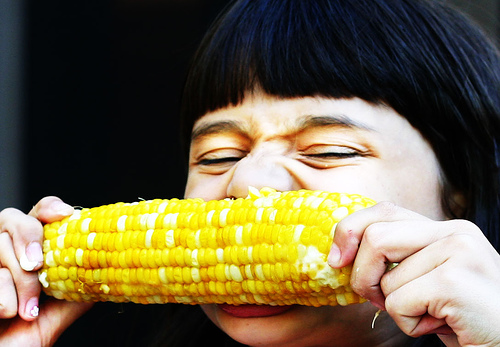

Actual Caption:  The child with black hair is eating corn on the cob .
Generated Caption:  A young boy is blowing bubbles with an orange blowing tube.


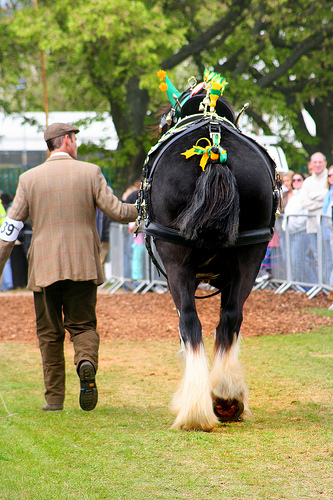

Actual Caption:  The man is walking with a draft horse
Generated Caption:  A black horse and its rider are admired by many people.


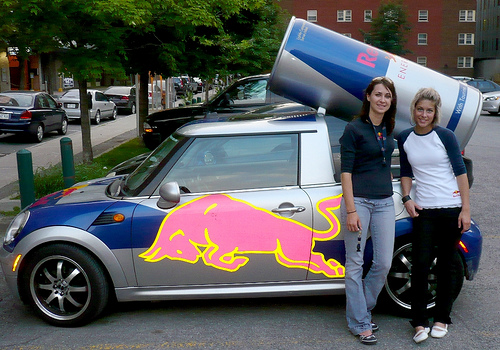

Actual Caption:  Two women standing beside a silver and blue car with a Redbull logo and a giant Redbull can on it .
Generated Caption:  A woman and a man are standing next to a car that has run off into a ditch.


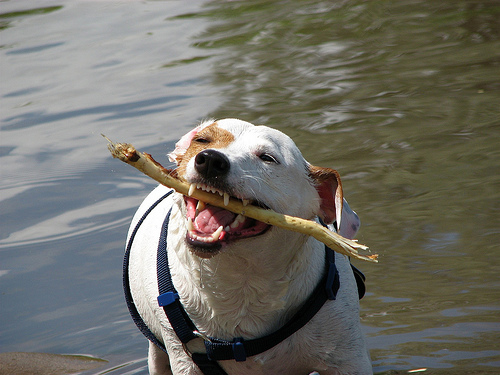

Actual Caption:  The white dog is standing in the water with a stick in its mouth .
Generated Caption:  A white and brown dog carries a stick in its mouth.


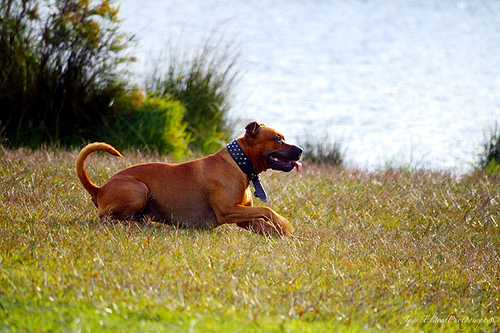

Actual Caption:  A brown dog on the grass next to a pond .
Generated Caption:  A brown dog is running through the grass towards the water.


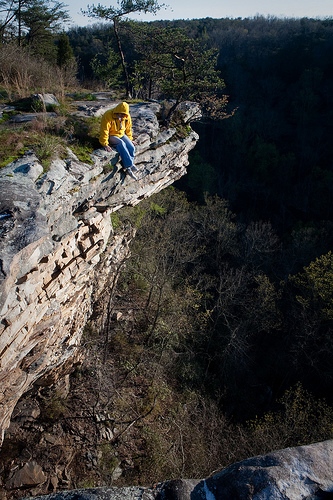

Actual Caption:  A person in a yellow raincoat is sitting on the edge of a rock looking down
Generated Caption:  A person in a yellow jacket is on a rock overlooking a forest.


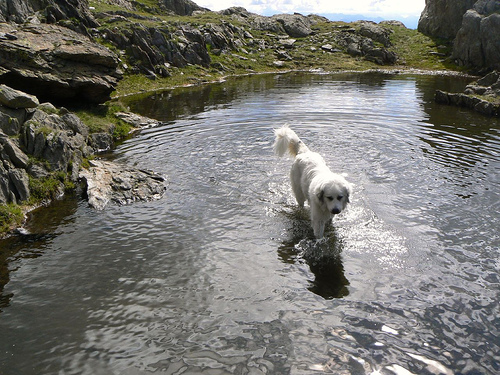

Actual Caption:  A dog in some water enclosed by rocky ledge .
Generated Caption:  A white dog is walking through a river.


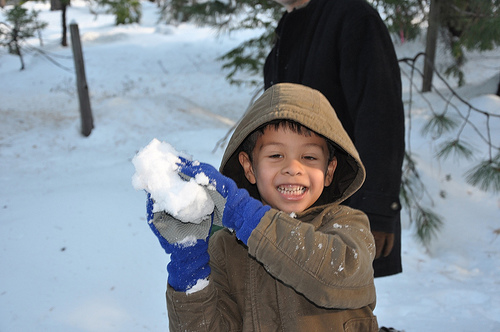

Actual Caption:  A young boy in a brown jacket playing with snow .
Generated Caption:  A child in winter gear holding a chunk of wood.


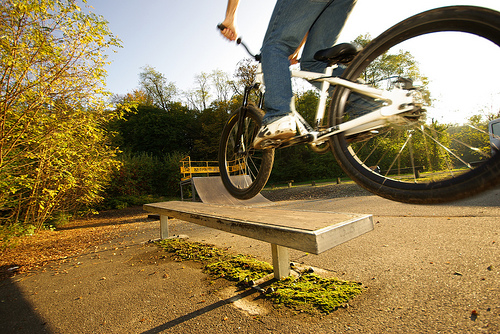

Actual Caption:  A person on a bmx bike , leaping onto a bench .
Generated Caption:  A bicyclist is attempting a trick on a wooden ramp.


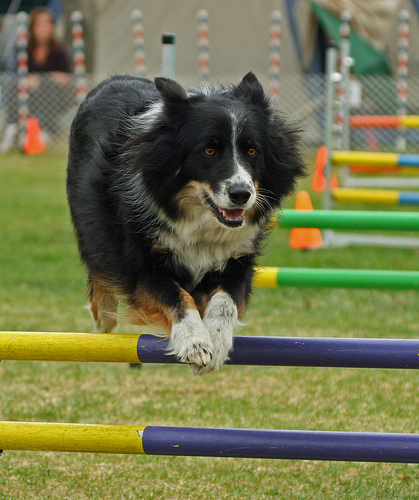

Actual Caption:  A dog jumping over a beam
Generated Caption:  A black and white dog is jumping over a hurdle.


In [ ]:
from PIL import Image

test_samples = test_df.sample(10)
test_images = test_samples['image'].values
test_captions = test_samples['caption'].values
img_dir = './Flickr8k/Images'

for idx, image_file in enumerate(test_images):
    image_path = os.path.join(img_dir, image_file)
    img =  Image.open(image_path).convert("RGB")
    display(img)
    print("Actual Caption: ", test_captions[idx])
    pixel_values = feature_extractor(img, return_tensors="pt").pixel_values.squeeze().to("cuda")
    pixel_values = pixel_values.to(device).unsqueeze(0)
    model = model.to(device)
    model_output = model.generate(pixel_values)
    generated_caption = tokenizer.decode(model_output[0], skip_special_tokens=True)
    generated_caption = generated_caption.split('.')[0] + '.'
    print("Generated Caption: ", generated_caption)